In [1]:
%load_ext autoreload
%autoreload 2

from snippets.loader import *
from snippets.torch_loader import *
from model import SSD300, MultiBoxLoss
from load_data import *
from utils import *
from load_data import *

keep_difficult = True

n_classes = len(label_map)
workers = 4
batch_size = 16


### Load Data

In [2]:
from pathlib import Path
_2007_root = Path("/home/yyr/data/VOCdevkit/VOC2007")
_2012_root = Path("/home/yyr/data/VOCdevkit/VOC2012")
train_items = get_items(_2007_root, 'train') + get_items(_2012_root, 'train')
val_items   = get_items(_2007_root, 'val')
logger.info(f'\n{len(train_items)} training images\n{len(val_items)} validation images')

train_dataset = VOCDataset(train_items, tfms=aug_trn)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)

val_dataset = VOCDataset(val_items, tfms=aug_val)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True,
                                           collate_fn=val_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)

2020-04-30 19:42:51.970 | INFO     | __main__:<module>:6 - 
8218 training images
2510 validation images


In [3]:
def train_one_epoch(train_loader, model, criterion, optimizer, epoch):
    model.train()
    N = len(train_loader)
    for bx, (images, boxes, labels, _) in enumerate(train_loader):
        images = images.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        _regr, _clss = model(images)
        loss = criterion(_regr, _clss, boxes, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        report.record(pos=epoch+((1+bx)/N), loss=loss.item(), end='\r')
    del _regr, _clss, images, boxes, labels
    
def validate(val_loader, model, criterion, epoch):
    model.eval()
    N = len(val_loader)
    for bx, (images, boxes, labels, _) in enumerate(val_loader):
        if bx % 10 != 0: continue # validate every 10th batch
        images = images.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        with torch.no_grad():
            _regr, _clss = model(images)
            loss = criterion(_regr, _clss, boxes, labels)
        report.record(pos=epoch+((1+bx)/N), val_loss=loss.item(), end='\r')
    del _regr, _clss, images, boxes, labels

In [4]:
epochs = 50

# mode = SSD300(n_classes=n_classes)
model = torch.load('ssd300.pth', map_location=device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-5)
model = model.to(device)
criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)
report = Report(n_epochs=epochs)

for epoch in range(epochs):
    train_one_epoch(train_loader, model, criterion, optimizer, epoch)
    validate(val_loader, model, criterion, epoch)
    report.report_avgs(epoch+1)
    torch.save(model, 'ssd300.pth')

/home/yyr/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


EPOCH: 1.000	loss: 4.270	val_loss: 4.290	(418.79s - 41460.35s remaining)
EPOCH: 2.000	loss: 3.908	val_loss: 4.020	(840.11s - 41165.48s remaining)
EPOCH: 3.000	loss: 3.647	val_loss: 4.070	(1245.98s - 40286.77s remaining)
EPOCH: 4.000	loss: 3.409	val_loss: 3.886	(1652.07s - 39649.72s remaining)
EPOCH: 5.000	loss: 3.216	val_loss: 3.853	(2058.28s - 39107.35s remaining)
EPOCH: 6.000	loss: 3.013	val_loss: 3.843	(2464.45s - 38609.77s remaining)
EPOCH: 7.000	loss: 2.810	val_loss: 3.820	(2870.81s - 38140.70s remaining)
EPOCH: 8.000	loss: 2.605	val_loss: 4.270	(3297.93s - 37926.24s remaining)
EPOCH: 9.000	loss: 2.444	val_loss: 4.212	(3727.81s - 37692.31s remaining)
EPOCH: 10.000	loss: 2.260	val_loss: 4.132	(4160.79s - 37447.14s remaining)
EPOCH: 11.000	loss: 2.091	val_loss: 4.356	(4575.00s - 37015.91s remaining)
EPOCH: 12.000	loss: 1.932	val_loss: 4.707	(4981.29s - 36529.44s remaining)
EPOCH: 13.000	loss: 1.799	val_loss: 4.815	(5387.47s - 36054.58s remaining)
EPOCH: 14.000	loss: 1.648	val_loss: 

KeyboardInterrupt: 

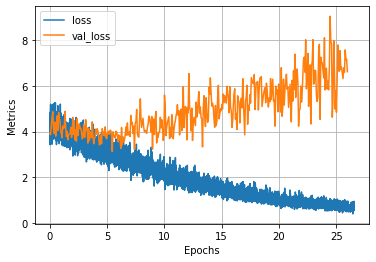

In [5]:
report.plot()